In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
from tqdm import *
from googletrans import *


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from transformers import BertTokenizer, TFBertModel , TFBertForSequenceClassification
from wordcloud import WordCloud , STOPWORDS 

## Data preporation 
### Reading train dataset

In [37]:
train = pd.read_table(
    './data/train', 
    delimiter='\t', 
    error_bad_lines=False, 
    header = None, 
    names = ['Id', 'Label', 'Comment']
)

# Changing order 
train  = train[['Id', 'Comment', 'Label']]

In [3]:
test = pd.read_table(
    'test', 
    header = None, 
    names = ['Id']
)

In [4]:
test.shape, test.head()

((99515, 1),
        Id
 0  167315
 1  224546
 2  241309
 3   31170
 4  173358)

In [5]:
train.shape, train.head()

((148775, 3),
        Id                                            Comment            Label
 0   41127                     дворника надо тоже уничтожить!  __label__THREAT
 1    6812  моя старшая неделю шипела, не принимала подкид...  __label__NORMAL
 2    6256                         полностью с вами согласна!  __label__NORMAL
 3  189636               хоть ногу вверх, ничего не изменится  __label__NORMAL
 4   99053                     а что значит - левого ребенка?  __label__NORMAL)

### Data preporation

In [6]:
# getting rid of '__label__'
def clear_label(label):
    return label.split('__label__')[1]
    
train['Label'] = train['Label'].apply(clear_label)
train = pd.concat([train.drop('Label', axis=1), pd.get_dummies(train['Label'])], axis=1)
train.head()

,Id,Comment,INSULT,NORMAL,OBSCENITY,THREAT
0,41127,дворника надо тоже уничтожить!,0,0,0,1
1,6812,"моя старшая неделю шипела, не принимала подкид...",0,1,0,0
2,6256,полностью с вами согласна!,0,1,0,0
3,189636,"хоть ногу вверх, ничего не изменится",0,1,0,0
4,99053,а что значит - левого ребенка?,0,1,0,0


In [7]:
train.isnull().values.any(), test.isnull().values.any()

(False, False)

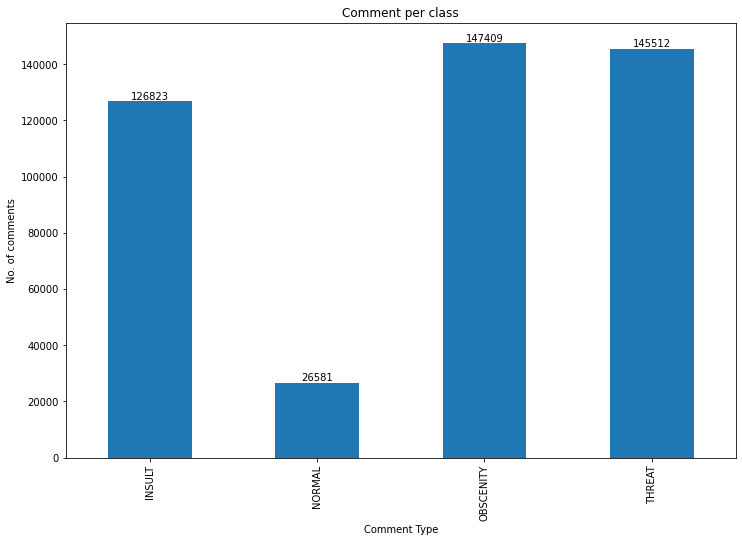

In [8]:
fr = [
    len(train[(train["INSULT"]==0)]) , 
    len(train[(train['NORMAL']==0)]) , 
    len(train[(train['OBSCENITY']==0)]) , 
    len(train[(train['THREAT']==0)])
]

freq_series = pd.Series(fr)
x_labels = ["INSULT" , "NORMAL" , "OBSCENITY" , "THREAT"]
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Comment per class')
ax.set_xlabel("Comment Type")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(x_labels)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

In [ ]:
sns.set()
sns.displot(train.iloc[:, 2:6], x ='flipper_length_mm')

#### 1) The data is imbalanced 
#### 2) All of the labels are sigle labeled in the data set.

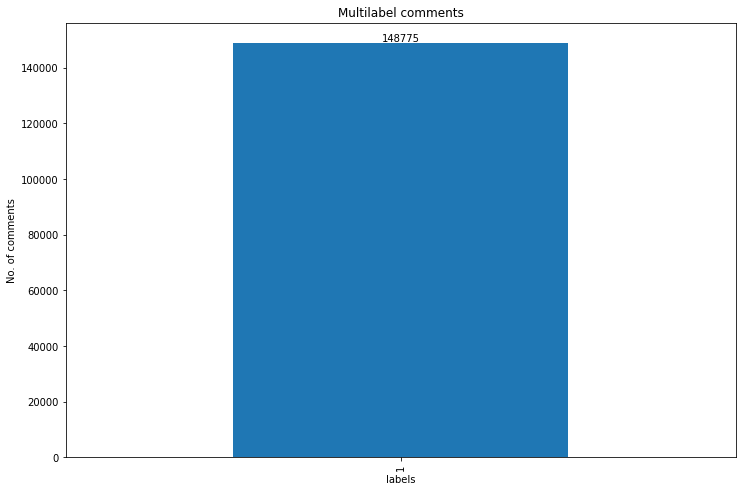

In [9]:
x = train[["INSULT" , "NORMAL"  ,"OBSCENITY" , "THREAT"]].sum(axis = 1).value_counts()
key = x.keys()
value = x.values

fr = pd.Series(value)
plt.figure(figsize=(12, 8))
ax = fr.plot(kind='bar')
ax.set_title('Multilabel comments')
ax.set_xlabel("labels")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(key)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

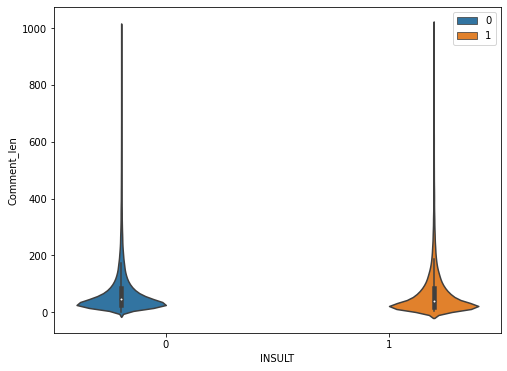

In [13]:
train["Comment_len"] = [len(i) for i in train.Comment.values]
plt.figure(figsize=(8,6))
ax = sns.violinplot(x="INSULT", y="Comment_len", data=train , hue = "INSULT")
plt.legend()
plt.show()
train = train.drop(["Comment_len"] , axis=1)


In [15]:
def plot_word_cloud(column: pd.core.series.Series):
    """ Plottingthe WordCloud image """
    wordcloud = WordCloud(
        width = 800, 
        height = 800, 
        background_color ='black', 
        max_words=2000,
        stopwords = STOPWORDS
    ).generate(column) 

    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
    plt.axis("off") 
    plt.tight_layout(pad = 0)

    plt.show() 

## Visualizing WordCloud

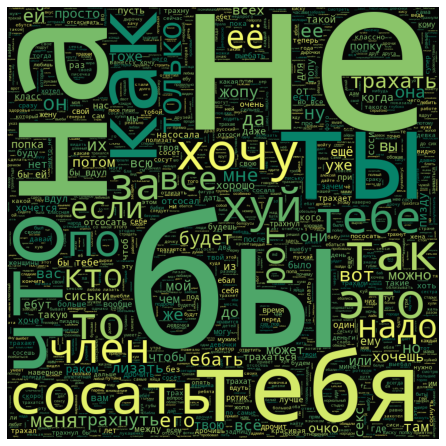

In [16]:
plot_word_cloud(''.join(train[train["OBSCENITY"]==1]['Comment']))

## Data Augmentation
### The idea behind this approche is simple:  extend dataset using google translator ( ru -> en -> ru)

In [ ]:
#  Ru -> En -> Ru example
translator = Translator()

encode = translator.translate(train.Comment.values[46] , dest='en').text
decode = translator.translate(encode , dest='ru').text
print(train.Comment.values[46])
print(decode)

In [ ]:
train_ru = []

for i in range(len(train.Comment.values)):
    encode_ru = translator.translate(train.Comment.values[0] , dest='en').text
    decode_ru = translator.translate(encode_ru , dest='ru').text
    train_ru.append(decode_ru)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
padded_ids_train = []
mask_ids_train = []

for i in tqdm(range(len(train.Comment.values))):
    encoding = tokenizer.encode_plus(
        train.Comment.values[i], max_length = 128 , pad_to_max_length = True  ,do_lower_case = False
    )
    
    input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"] 
    padded_ids_train.append(input_ids)
    mask_ids_train.append(attention_id)

100%|██████████| 148775/148775 [03:49<00:00, 649.03it/s]


In [21]:
y_train = train.iloc[:, 2:6]

train_id = np.array(padded_ids_train)
train_mask = np.array(mask_ids_train)


In [28]:
input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)
input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
output  = model([input_1 , input_2] , training = True)
answer = tf.keras.layers.Dense(4 , activation = tf.nn.sigmoid )(output[0])
model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [answer])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         109483778   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            12          tf_bert_for_sequence_classi

In [24]:
%load_ext tensorboard

In [31]:
auc_score = AUC(multi_label=True)
model.compile(
    optimizer = Adam(lr = 3e-5),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = [ auc_score]
)

In [26]:
log_dir = "./logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

filepath = "./final_model.h5"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_auc',
    verbose=1,
    save_best_only=True ,
    mode = "max" ,
    save_weights_only = True
)

In [32]:
model.fit(
    [train_id , train_mask] , 
    y_train,
    validation_split = 0.1, 
    batch_size = 32, 
    epochs=4, 
    callbacks = [tensorboard_callback , checkpoint]
)

Epoch 1/4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
   3/4185 [..............................] - ETA: 53:49:52 - loss: 0.6512 - auc_1: 0.3943

KeyboardInterrupt: 